### Let's build the regressors one by one
* Idea was to build a bunch of regressors and try for a multitude of features.
* Due to time constraint could only build one.
* Would build more models and train on the entire dataset to obtain test data results before the report submission rate.

In [58]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor 
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

### Decision Trees

In [3]:
def calc_rmsle(predictions, observations):
    total = 0 
    ## for all the predicted and actual values
    for i in range(len(predictions)):
        
        ## Take log of predicted values and add 1 to prevent underflow
        pred= np.log1p(predictions[i]+1)
        ## Take log of actual values and add 1 to prevent underflow
        targ = np.log1p(observations[i] + 1)
        
        ## if predicted and actual values are not a number then don't go 
        if not (math.isnan(pred)) and  not (math.isnan(targ)): 
            ## summation of squares of difference of logarithmic predicted and target value
            total = total + ((pred-targ) **2)
        else:
            raise Exception("predicted or actual value is not a number! | predicted : {}, target : {}".format(pred,targ))
    
    ## taking mean of the summated value
    total = total / len(predictions)        
    ## Performing square root of that value
    return np.sqrt(total)

In [48]:
max_depth_params = [3,5,10,20,30]
min_samples_split_params = [i for i in np.linspace(0.1,1,10)]
max_leaf_nodes_params = [i for i in range(2,100,10)]

### Data preparation for train data

In [5]:
train_df = pd.read_csv("../csv_files/train.csv")
train_df['grain'] = train_df['store_nbr'].astype('str') + '_' + train_df['item_nbr'].astype('str')

In [6]:
def create_individual_date_cols(ts):
    # converting to datetime
    ts['day'] = ts.date.dt.day
    ts['wday'] = ts.date.dt.weekday
    ts['year'] = ts.date.dt.year
    ts['month'] = ts.date.dt.month
    ts['week'] = ts.date.dt.isocalendar().week
    return ts

In [7]:
train_df['date'] = pd.to_datetime(train_df['date'])

In [8]:
train_df = create_individual_date_cols(train_df)

### 1. Testing on a sample grain

#### 1.1 Creating empty dataframes for train and test

In [25]:
train_data = pd.DataFrame()
val_data = pd.DataFrame()

#### 1.2 Selecting the grain to be worked on and creating the train validation split

In [26]:
grain_index = train_df[train_df['grain'] == '15_45'].index 
train_len = math.floor(len(grain_index)  * 0.9)
train_index = grain_index[:train_len]
val_index = grain_index[train_len:]
train_data = train_df.loc[train_index,:]
val_data = train_df.loc[val_index,:]

#### 1.3 Creating X and y for both train and validation split

In [27]:
train_x = train_data.drop(columns = ['units'])
train_y = train_data['units']
val_x = val_data.drop(columns = ['units'])
val_y = val_data['units']

#### 1.2.a Creating a function to be used again later

In [9]:
def split_dataset(inp_df):
    grain_index = inp_df.index 
    train_len = math.floor(len(grain_index)  * 0.9)
    train_index = grain_index[:train_len]
    val_index = grain_index[train_len:]
    train_data = inp_df.loc[train_index,:]
    val_data = inp_df.loc[val_index,:]
    
    train_x = train_data.drop(columns = ['units'])
    train_y = train_data['units']
    val_x = val_data.drop(columns = ['units'])
    val_y = val_data['units']
    return train_x, train_y, val_x, val_y

#### 1.4 Training the Decision Tree Regressor
* Creating a Decision Tree Regressor
* Using loops as grid search cv for hyper-parameter optimization
* Obtaining the best set of hyper-parameters using validation data

In [49]:
# create a regressor object
min_rmsle = np.inf

best_depth = -1
best_min_samples = -1
best_max_leaf_nodes = -1

for depth in max_depth_params:
    for min_samples in min_samples_split_params:
        for max_leafs in max_leaf_nodes_params:
            regressor = DecisionTreeRegressor(max_depth=depth,
                                              min_samples_split = min_samples,
                                              max_leaf_nodes = max_leafs)
            regressor.fit(train_x, train_y)
            val_pred = regressor.predict(val_x)
            rmsle = calc_rmsle(val_y.values,val_pred)
            if rmsle < min_rmsle:
                best_depth = depth
                best_min_samples = min_samples
                best_max_leaf_nodes = max_leafs
                min_rmsle = rmsle
print("Best depth to train decision tree regressor : ",best_depth)
print("Best minimum number of samples to train decision tree regressor : ",best_min_samples)
print("Best maximum leaf nodes to train decision tree regressor : ",best_max_leaf_nodes)
print("Best RMSLE observed while training decision tree regressor : ",min_rmsle)

Best depth to train decision tree regressor :  5
Best minimum number of samples to train decision tree regressor :  0.1
Best maximum leaf nodes to train decision tree regressor :  22
Best RMSLE observed while training decision tree regressor :  0.35793834116106593


#### 1.4.a Creating a function to train decision tree regressor

In [10]:
def tune_decision_tree_regressor(hyper_params, train_x, train_y, val_x, val_y):
    min_rmsle = np.inf
    best_depth = -1
    best_min_samples = -1
    best_max_leaf_nodes = -1
    best_hyper_params = dict()
    
    max_depth_params = hyper_params['max_depth_params']
    min_samples_split_params = hyper_params['min_samples_split_params']
    max_leaf_nodes_params = hyper_params['max_leaf_nodes_params']
    
    for depth in max_depth_params:
        for min_samples in min_samples_split_params:
            for max_leafs in max_leaf_nodes_params:
                regressor = DecisionTreeRegressor(max_depth=depth,
                                                  min_samples_split = min_samples,
                                                  max_leaf_nodes = max_leafs)
                regressor.fit(train_x, train_y)
                val_pred = regressor.predict(val_x)
                rmsle = calc_rmsle(val_y.values,val_pred)
                if rmsle < min_rmsle:
                    best_hyper_params['best_depth'] = depth
                    best_hyper_params['best_min_samples'] = min_samples
                    best_hyper_params['best_max_leaf_nodes'] = max_leafs
                    min_rmsle = rmsle
    
    print("Best depth to train decision tree regressor : ",best_hyper_params['best_depth'])
    print("Best minimum number of samples to train decision tree regressor : ",best_hyper_params['best_min_samples'])
    print("Best maximum leaf nodes to train decision tree regressor : ",best_hyper_params['best_max_leaf_nodes'])
    print("Best RMSLE observed while training decision tree regressor : ",min_rmsle)
    regressor = DecisionTreeRegressor(max_depth = best_hyper_params['best_depth'],
                                      min_samples_split = best_hyper_params['best_min_samples'],
                                      max_leaf_nodes = best_hyper_params['best_max_leaf_nodes'])
    regressor.fit(train_x, train_y)
    predictions = regressor.predict(val_x)
    return best_hyper_params, min_rmsle, regressor, predictions

### 2. Obtain the feature Importances

#### Fit a model with the best hyper-parameters

In [53]:
regressor = DecisionTreeRegressor(max_depth=5,
                                  min_samples_split = 0.1,
                                  max_leaf_nodes = 22)
regressor.fit(train_x,train_y)

DecisionTreeRegressor(max_depth=5, max_leaf_nodes=22, min_samples_split=0.1)

#### 2.1 Get feature importances

In [57]:
feature_columns = train_x.columns
feature_importances = regressor.feature_importances_

In [60]:
feat_imp_dict = dict(zip(feature_columns,feature_importances))
feat_imp_df = pd.DataFrame()
feat_imp_df['cols'] = feat_imp_dict.keys()
feat_imp_df['imp_vals'] = feat_imp_dict.values()

<AxesSubplot:xlabel='cols', ylabel='imp_vals'>

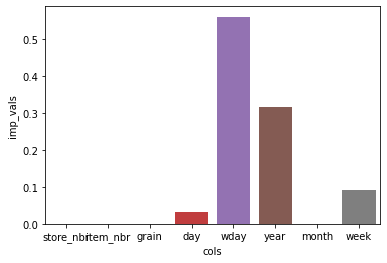

In [62]:
sns.barplot(x = 'cols', y = 'imp_vals', data = feat_imp_df)

#### 2.1.a Creating a function to obtain feature importances

In [153]:
def get_feature_importances(inp_x, regressor):
    feature_columns = inp_x.columns
    feature_importances = regressor.feature_importances_
    feat_imp_dict = dict(zip(feature_columns,feature_importances))
    feat_imp_df = pd.DataFrame()
    feat_imp_df['cols'] = feat_imp_dict.keys()
    feat_imp_df['imp_vals'] = feat_imp_dict.values()
    fig,ax1 = plt.subplots(nrows = 1,ncols = 1,figsize=(20,10))
    plt.xticks(rotation = 45)
    sns.barplot(x = 'cols', y = 'imp_vals', data = feat_imp_df,ax=ax1)

#### Let's add more features and see if results improve

In [13]:
weather_df = pd.read_csv('../csv_files/weather_df.csv')

In [21]:
weather_df['date'] = pd.to_datetime(weather_df['date'])

In [14]:
weather_df.head()

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,codesum_rev
0,1,2012-01-01,52.0,31.0,42.0,-503.825359,36.0,40.0,23.0,0.0,...,-1000,RA FZFG BR,-201.753454,0.05,29.78,29.92,3.6,20.0,4.6,"['RA', 'FZ', 'FG', 'BR']"
1,2,2012-01-01,48.0,33.0,41.0,16.000000,37.0,39.0,24.0,0.0,...,1626,RA,0.000000,0.07,28.82,29.91,9.1,23.0,11.3,['RA']
2,3,2012-01-01,55.0,34.0,45.0,9.000000,24.0,36.0,20.0,0.0,...,1720,RA,0.000000,0.00,29.77,30.47,9.9,31.0,10.0,['RA']
3,4,2012-01-01,63.0,47.0,55.0,4.000000,28.0,43.0,10.0,0.0,...,1742,BR,0.000000,0.00,29.79,30.48,8.0,35.0,8.2,['BR']
4,6,2012-01-01,63.0,34.0,49.0,0.000000,31.0,43.0,16.0,0.0,...,1742,BR,0.000000,0.00,29.95,30.47,14.0,36.0,13.8,['BR']


In [15]:
weather_df.drop(columns = ['codesum'],inplace=True)

In [16]:
def check_weather_conditions(x,is_mild=True):
    if is_mild:
        mild_weather_cond = ['DZ','RA','SN','SG','BR','HZ']
        for weather_cond in mild_weather_cond:
            if weather_cond in x:
                return 1
            else:
                return 0 
    else:
        extreme_weather_cond = ['TS','FC','SS','DS','FG','VA','GR','FU','DU']
        for weather_cond in extreme_weather_cond:
            if weather_cond in x:
                return 1
            else:
                return 0

In [17]:
weather_df['extreme_weather'] = weather_df['codesum_rev'].apply(lambda x : check_weather_conditions(x,is_mild=False))
weather_df['mild_weather'] = weather_df['codesum_rev'].apply(lambda x : check_weather_conditions(x))

In [19]:
key_df = pd.read_csv('../csv_files/key.csv')

* Since we are only dealing with store number 15, let's find out the station nbr corresponding to it

In [74]:
station_nbr = key_df[key_df['store_nbr'] == 15]['station_nbr'].values[0]
print("Station number corresponding to store 15 : ",station_nbr)

Station number corresponding to store 15 :  13


In [85]:
weather_df['date'] = pd.to_datetime(weather_df['date'])

In [22]:
key_subs_df = key_df[key_df['store_nbr'] == 15]
train_subs_df = train_df[train_df['grain'] == '15_45']
train_key_merge_df = pd.merge(train_subs_df,key_subs_df,on='store_nbr',how='left')
train_weather_df = pd.merge(train_key_merge_df, weather_df, on = ['station_nbr','date'], how='inner')

In [23]:
train_weather_df.shape

(1011, 31)

In [24]:
train_weather_df.head()

,date,store_nbr,item_nbr,units,grain,day,wday,year,month,week,...,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,codesum_rev,extreme_weather,mild_weather
0,2012-01-01,15,45,108,15_45,1,6,2012,1,52,...,-201.753454,0.0,24.60,30.59,2.5,16.0,6.1,"['SN', 'BR']",0,0
1,2012-01-02,15,45,160,15_45,2,0,2012,1,1,...,-201.753454,0.0,24.55,30.54,6.1,16.0,6.8,"['SN', 'BR']",0,0
2,2012-01-03,15,45,128,15_45,3,1,2012,1,1,...,-201.753454,0.0,24.40,30.23,2.9,21.0,6.3,"['SN', 'BR']",0,0
3,2012-01-04,15,45,100,15_45,4,2,2012,1,1,...,-201.753454,0.0,24.49,30.36,5.5,19.0,6.1,"['SN', 'BR']",0,0
4,2012-01-05,15,45,103,15_45,5,3,2012,1,1,...,-201.753454,0.0,24.26,30.04,4.2,21.0,5.0,"['SN', 'BR']",0,0


In [96]:
train_weather_df.drop(columns = ['date','codesum_rev'],inplace=True)

In [97]:
train_weather_df.shape

(1011, 29)

#### Splitting the above dataset into train and validation

In [111]:
train_x, train_y,val_x,val_y = split_dataset(train_weather_df)
print("Shape of train_x : ",train_x.shape)
print("Shape of train_y : ",train_y.shape)
print("Shape of val_x : ",val_x.shape)
print("Shape of val_y : ",val_y.shape)

Shape of train_x :  (909, 28)
Shape of train_y :  (909,)
Shape of val_x :  (102, 28)
Shape of val_y :  (102,)


In [112]:
hyper_params = dict()
hyper_params['max_depth_params'] = [3,5,10,20,30]
hyper_params['min_samples_split_params'] = [i for i in np.linspace(0.1,1,10)]
hyper_params['max_leaf_nodes_params'] = [i for i in range(2,100,10)]

In [127]:
best_hyper_params, rmsle ,regressor, predictions = tune_decision_tree_regressor(hyper_params, train_x, train_y, val_x, val_y)

Best depth to train decision tree regressor :  5
Best minimum number of samples to train decision tree regressor :  0.1
Best maximum leaf nodes to train decision tree regressor :  22
Best RMSLE observed while training decision tree regressor :  0.35793834116106593


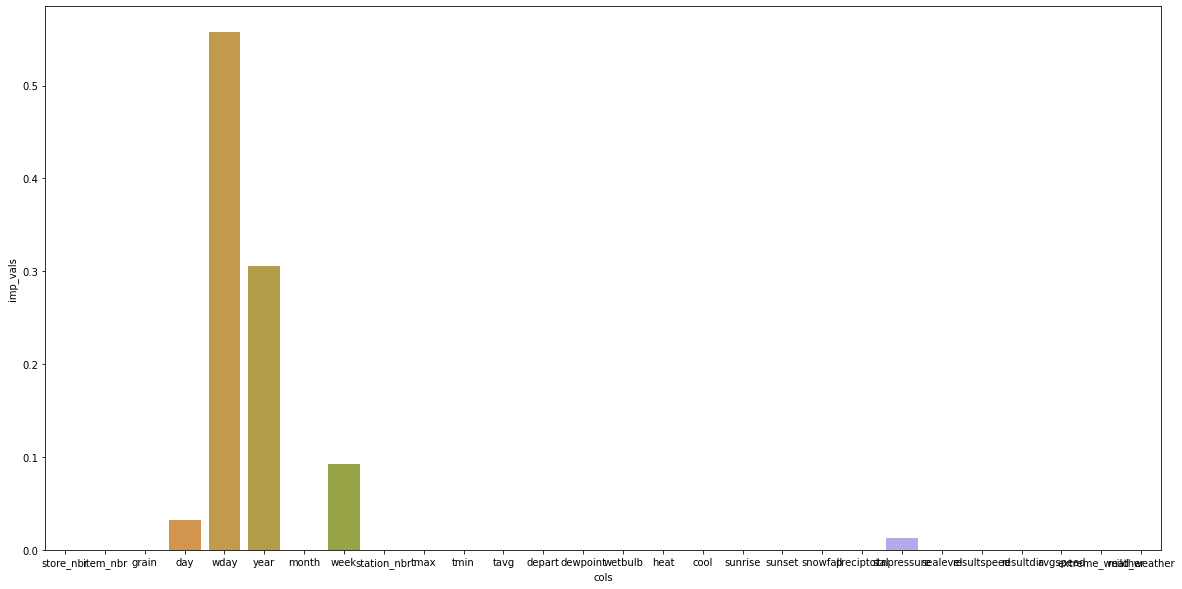

In [125]:
get_feature_importances(train_x, regressor)

### Let's plot the actual values v/s predictions

In [25]:
def plot_observations_predictions(observations, predictions):
    plt.rc("figure", figsize=(25, 8))
    plt.rc("font", size=12)

    plt.plot(observations,color="blue",label='observations')
    plt.plot(predictions, color='red',label='predictions')
    plt.title("Plot of Predictions and Observed values")
    plt.legend(loc="upper right")
    plt.xlabel("time")
    plt.ylabel("units")
    
    plt.show()

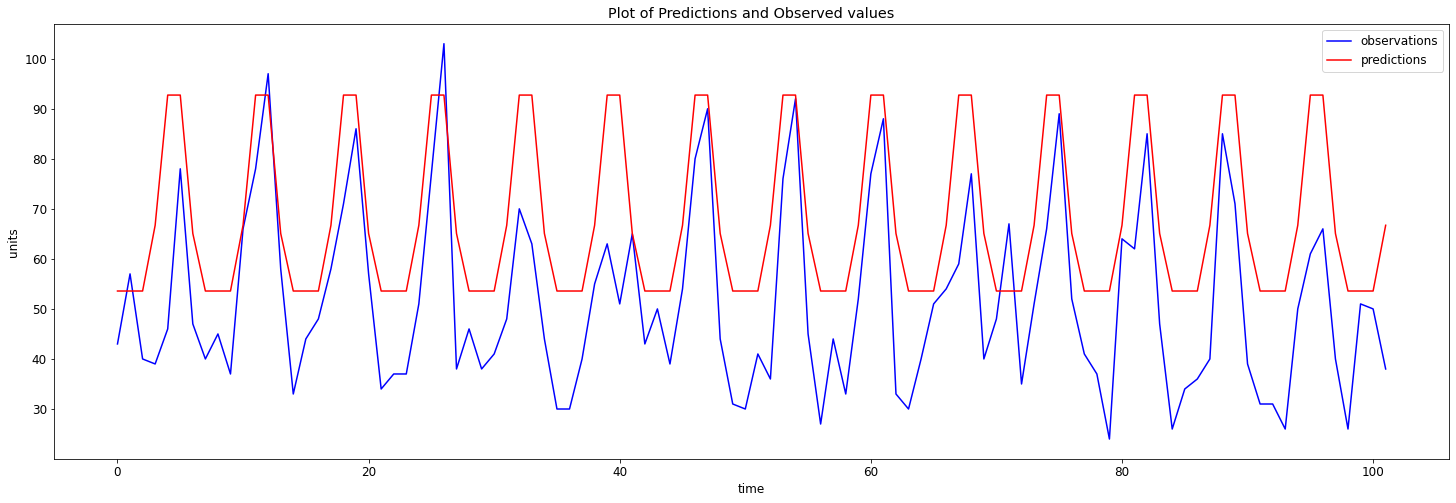

In [133]:
plot_observations_predictions(val_y.values, predictions)

* It's able to capture seasonality.
* We have trained these model for a single grain.
* Would expect better results if we train it for the whole data.

### Let's build a Random Forest Regressor

#### Hyperparameters we'd like to try for our regressor

In [96]:
rf_hyper_params = dict()
rf_hyper_params['n_estimators'] = [i for i in range(10,100,10)]
rf_hyper_params['max_depth'] = [3,5,10,20,30]
rf_hyper_params['n_jobs'] = [-1]

#### Instead of using a splitter in Grid Search CV, I am writing my own GridSearchCV to avoid any errors related to validation data testing
* We cannot dynamically create for loops.
* Instead we can create the actual grid of hyper-parameters and use each of them to test our model.

In [35]:
import itertools

#### Creating a dictionary of hyper_parameters

In [40]:
list_of_hyper_params = [val for val in rf_hyper_params.values()]
list_of_hyper_param_combination = list(itertools.product(*list_of_hyper_params))
hyper_params_keys = tuple(rf_hyper_params.keys())

In [42]:
from sklearn.ensemble import RandomForestRegressor

#### Selecting a single grain from the entire train data

In [90]:
grain_df = train_df[train_df['grain'] == '15_45']

In [91]:
train_x,train_y, val_x, val_y = split_dataset(grain_df.drop(columns=['date']))

In [92]:
def evaluate_rf_regressor(dict_of_hyper_params, train_x, train_y, val_x, val_y, index):
    random_forest_regressor = RandomForestRegressor(**dict_of_hyper_params)
    random_forest_regressor.fit(train_x, train_y)
    val_pred = random_forest_regressor.predict(val_x)

    rmsle = calc_rmsle(val_y.values,val_pred)
    print("Completed execution for index : ",index)
    return (index,rmsle)

In [93]:
import time
from joblib import Parallel, delayed

In [147]:
def tune_rf_regressor(rf_hyper_params,train_x, train_y, val_x, val_y):
    min_rmsle = np.inf
    best_hyper_params = None

    hp_list = [val for val in rf_hyper_params.values()]
    hp_combination = list(itertools.product(*hp_list))
    hp_keys = tuple(rf_hyper_params.keys())


    rmsle_list = Parallel(n_jobs=6,verbose=1)(delayed(evaluate_rf_regressor)
              (dict(zip(hp_keys,hp_combination[hp_index])),
               train_x, train_y, val_x, val_y, hp_index) 
               for hp_index in range(len(hp_combination)))

    for index in range(len(rmsle_list)):
        if rmsle_list[index][1] < min_rmsle:
            min_rmsle = rmsle_list[index][1]
            best_hyper_params = dict(zip(hp_keys,hp_combination[rmsle_list[index][0]]))

    rf_regressor = RandomForestRegressor(**best_hyper_params)
    rf_regressor.fit(train_x, train_y)
    predictions = rf_regressor.predict(val_x)  
    print("Best Hyper Params : ", best_hyper_params)
    print("Min RMSLE : ", min_rmsle)
    return best_hyper_params, min_rmsle, rf_regressor, predictions

In [139]:
best_hyper_params, min_rmsle, rf_regressor, predictions = tune_rf_regressor(rf_hyper_params, train_x, train_y, val_x, val_y)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Best Hyper Params :  {'n_estimators': 10, 'max_depth': 20, 'n_jobs': -1}
Min RMSLE :  0.3131623755310188


[Parallel(n_jobs=6)]: Done  45 out of  45 | elapsed:    1.4s finished


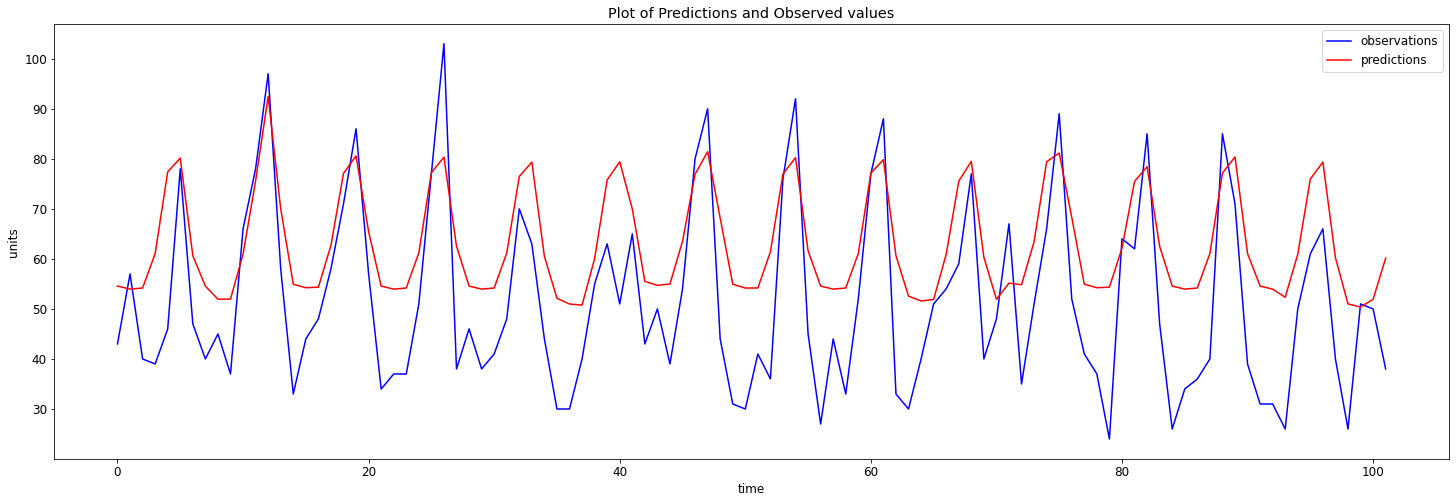

In [140]:
plot_observations_predictions(val_y.values, predictions)

### Let's add more features and see if we can do better

In [143]:
train_weather_df.to_csv('./train_weather_df.csv')

In [145]:
train_x, train_y, val_x, val_y = split_dataset(train_weather_df.drop(columns = ['date','codesum_rev']))

In [148]:
best_hyper_params, min_rmsle, rf_regressor, predictions = tune_rf_regressor(rf_hyper_params, train_x, train_y, val_x, val_y)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Best Hyper Params :  {'n_estimators': 30, 'max_depth': 20, 'n_jobs': -1}
Min RMSLE :  0.3155601946634875


[Parallel(n_jobs=6)]: Done  45 out of  45 | elapsed:    2.1s finished


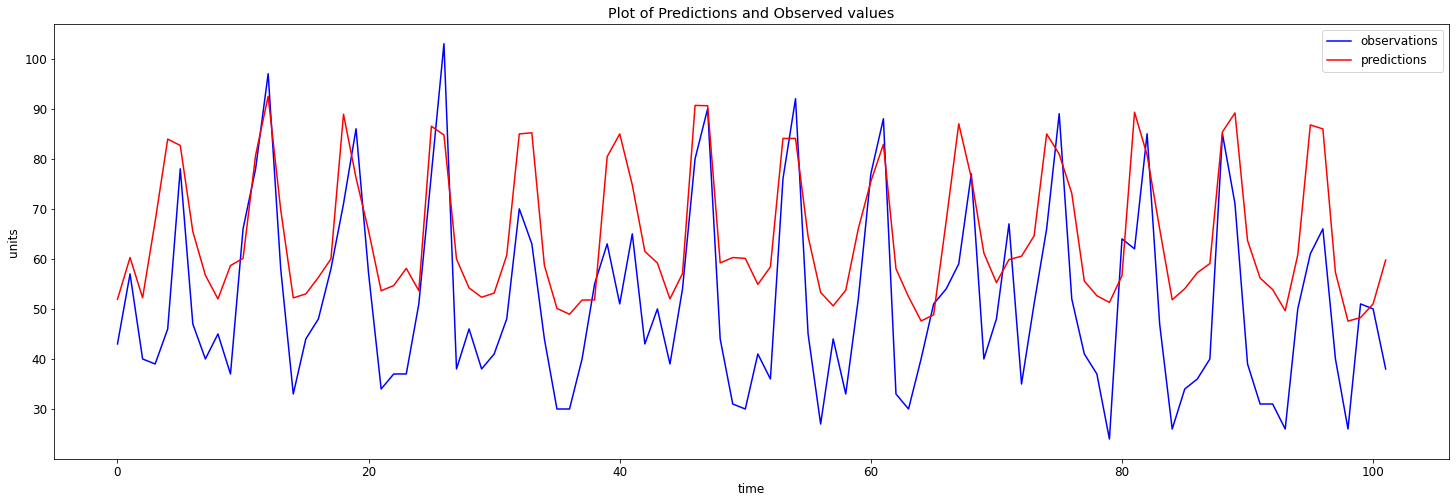

In [149]:
plot_observations_predictions(val_y.values, predictions)

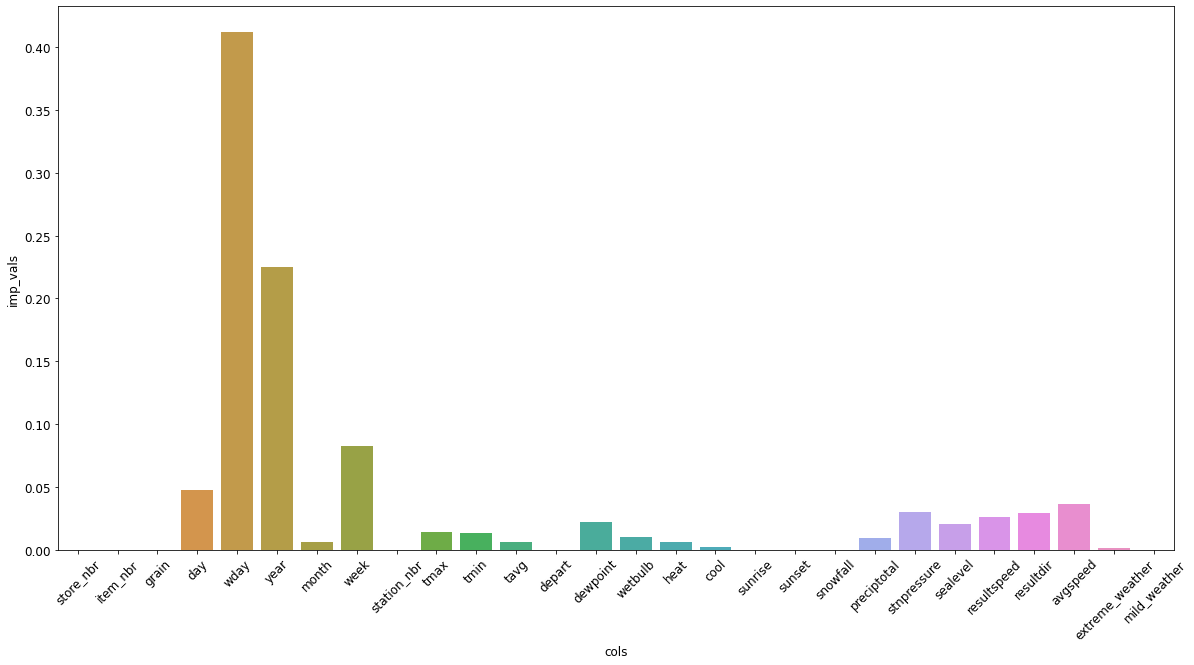

In [154]:
get_feature_importances(train_x, rf_regressor)

* There are two significant observations
    * Date related features are most influential.
    * Our model is able to predict the peaks very well, but not the dips.
* So according to me these date features are predicting the peaks very well, but there must be something which predicts the dips as well.
* Let's try build more features using Polynomial transform.

In [155]:
from sklearn.preprocessing import PolynomialFeatures

In [168]:
common_feat = list(set(train_weather_df.columns).intersection(set(weather_df.columns)))
unwanted_feat = ['codesum_rev','station_nbr','depart','sunrise','sunset','extreme_weather','mild_weather','date']
transform_feat = [feat for feat in common_feat if feat not in unwanted_feat]

In [193]:
poly_features = PolynomialFeatures(degree=2)
poly_feature_arr = poly_features.fit_transform(train_weather_df[transform_feat])

In [194]:
poly_feature_arr.shape

(1011, 120)

* A total of 120 more features added.

In [195]:
poly_features_df = pd.DataFrame(columns = poly_features.get_feature_names(), data = poly_feature_arr)

In [196]:
poly_features_df.head()

,1,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x10^2,x10 x11,x10 x12,x10 x13,x11^2,x11 x12,x11 x13,x12^2,x12 x13,x13^2
0,1.0,30.59,21.0,2.5,0.0,38.0,12.0,37.0,24.60,6.1,...,324.0,288.0,-3631.562173,504.0,256.0,-3228.055265,448.0,40704.456231,-5649.096714,784.0
1,1.0,30.54,28.0,6.1,0.0,50.0,17.0,32.0,24.55,6.8,...,256.0,256.0,-3228.055265,528.0,256.0,-3228.055265,528.0,40704.456231,-6657.863984,1089.0
2,1.0,30.23,33.0,2.9,0.0,55.0,16.0,22.0,24.40,6.3,...,961.0,651.0,-6254.357076,1333.0,441.0,-4236.822536,903.0,40704.456231,-8675.398525,1849.0
3,1.0,30.36,32.0,5.5,0.0,58.0,16.0,22.0,24.49,6.1,...,729.0,513.0,-5447.343260,1161.0,361.0,-3833.315627,817.0,40704.456231,-8675.398525,1849.0
4,1.0,30.04,37.0,4.2,0.0,66.0,21.0,14.0,24.26,5.0,...,1225.0,735.0,-7061.370893,1785.0,441.0,-4236.822536,1071.0,40704.456231,-10289.426158,2601.0


In [197]:
train_poly_df = pd.concat([train_weather_df, poly_features_df],axis=1)
train_poly_df.head()

,date,store_nbr,item_nbr,units,grain,day,wday,year,month,week,...,x10^2,x10 x11,x10 x12,x10 x13,x11^2,x11 x12,x11 x13,x12^2,x12 x13,x13^2
0,2012-01-01,15,45,108,15_45,1,6,2012,1,52,...,324.0,288.0,-3631.562173,504.0,256.0,-3228.055265,448.0,40704.456231,-5649.096714,784.0
1,2012-01-02,15,45,160,15_45,2,0,2012,1,1,...,256.0,256.0,-3228.055265,528.0,256.0,-3228.055265,528.0,40704.456231,-6657.863984,1089.0
2,2012-01-03,15,45,128,15_45,3,1,2012,1,1,...,961.0,651.0,-6254.357076,1333.0,441.0,-4236.822536,903.0,40704.456231,-8675.398525,1849.0
3,2012-01-04,15,45,100,15_45,4,2,2012,1,1,...,729.0,513.0,-5447.343260,1161.0,361.0,-3833.315627,817.0,40704.456231,-8675.398525,1849.0
4,2012-01-05,15,45,103,15_45,5,3,2012,1,1,...,1225.0,735.0,-7061.370893,1785.0,441.0,-4236.822536,1071.0,40704.456231,-10289.426158,2601.0


In [198]:
train_x, train_y, val_x, val_y = split_dataset(train_poly_df.drop(columns = ['date', 'codesum_rev']))

In [199]:
best_hyper_params, min_rmsle, rf_regressor, predictions = tune_rf_regressor(rf_hyper_params, train_x, train_y, val_x, val_y)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  34 out of  45 | elapsed:    8.0s remaining:    2.6s


Best Hyper Params :  {'n_estimators': 10, 'max_depth': 5, 'n_jobs': -1}
Min RMSLE :  0.3276357294138547


[Parallel(n_jobs=6)]: Done  45 out of  45 | elapsed:   10.7s finished


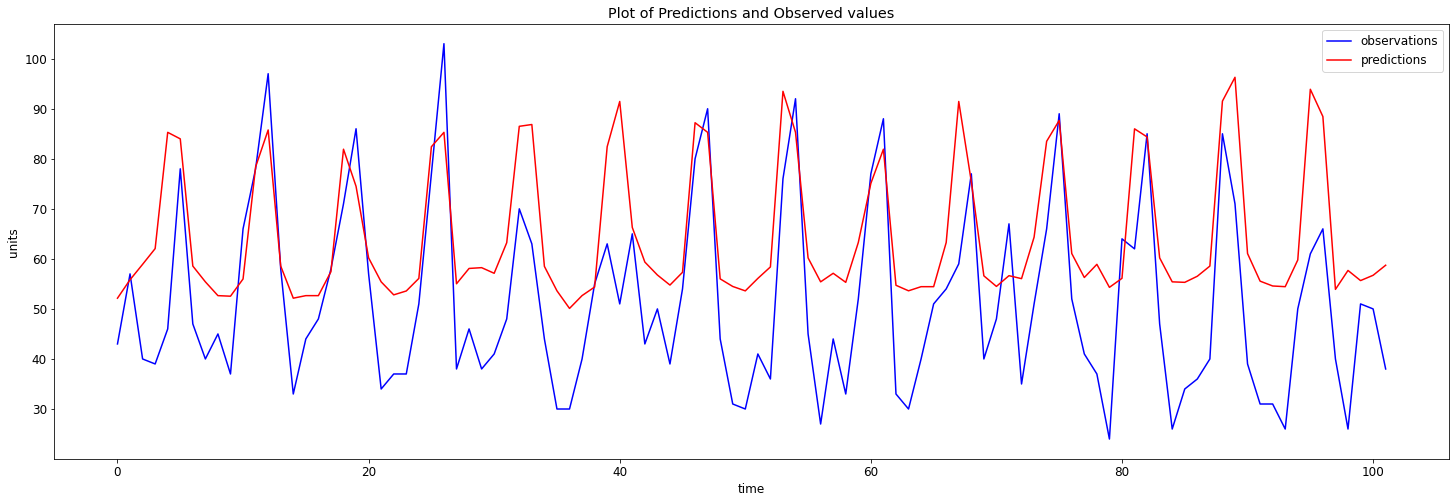

In [200]:
plot_observations_predictions(val_y.values, predictions)

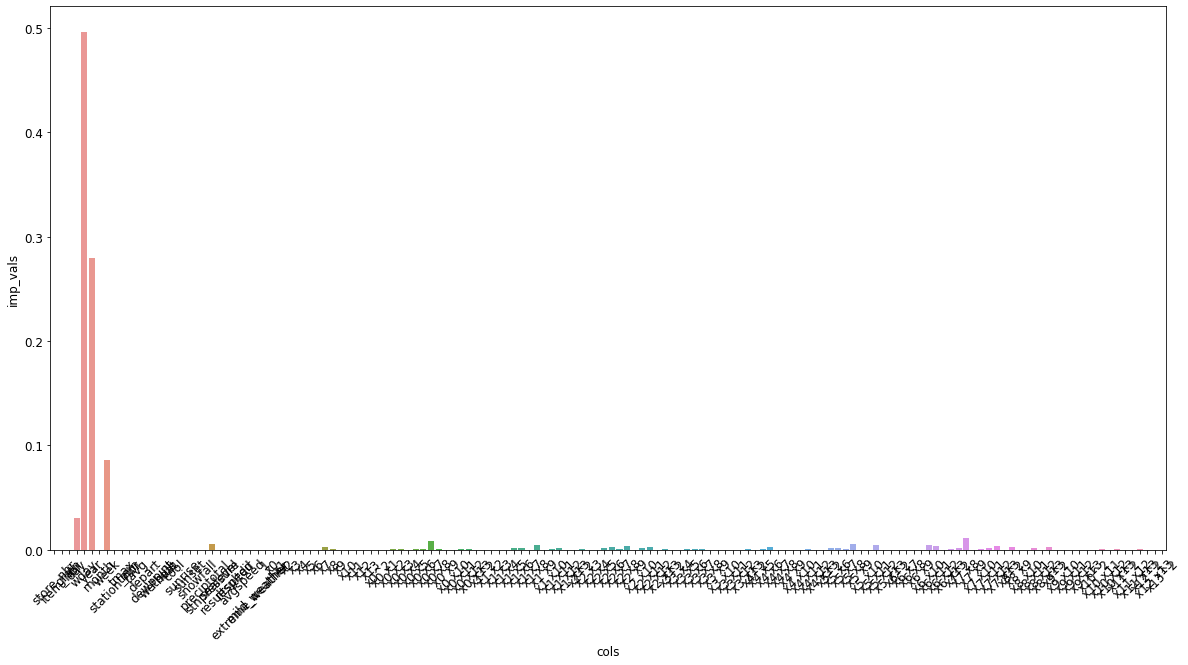

In [201]:
get_feature_importances(train_x, rf_regressor)

#### Let's just look at feature interactions only

In [190]:
def create_polynomial_features(data, degree, interaction_only_param = False, include_bias_param = True):
    poly_features = PolynomialFeatures(degree=2, 
                                       interaction_only = interaction_only_param,
                                       include_bias = include_bias_param)
    poly_feature_arr = poly_features.fit_transform(data)
    poly_features_df = pd.DataFrame(columns = poly_features.get_feature_names(), data = poly_feature_arr)
    return poly_features_df

In [191]:
poly_features_df = create_polynomial_features(train_weather_df[transform_feat], degree = 2, interaction_only_param=True, include_bias_param=False)
train_poly_df = pd.concat([train_weather_df,poly_features_df], axis = 1)
train_poly_df.head()

,date,store_nbr,item_nbr,units,grain,day,wday,year,month,week,...,x9 x10,x9 x11,x9 x12,x9 x13,x10 x11,x10 x12,x10 x13,x11 x12,x11 x13,x12 x13
0,2012-01-01,15,45,108,15_45,1,6,2012,1,52,...,0.0,0.0,-0.0,0.0,288.0,-3631.562173,504.0,-3228.055265,448.0,-5649.096714
1,2012-01-02,15,45,160,15_45,2,0,2012,1,1,...,0.0,0.0,-0.0,0.0,256.0,-3228.055265,528.0,-3228.055265,528.0,-6657.863984
2,2012-01-03,15,45,128,15_45,3,1,2012,1,1,...,0.0,0.0,-0.0,0.0,651.0,-6254.357076,1333.0,-4236.822536,903.0,-8675.398525
3,2012-01-04,15,45,100,15_45,4,2,2012,1,1,...,0.0,0.0,-0.0,0.0,513.0,-5447.343260,1161.0,-3833.315627,817.0,-8675.398525
4,2012-01-05,15,45,103,15_45,5,3,2012,1,1,...,0.0,0.0,-0.0,0.0,735.0,-7061.370893,1785.0,-4236.822536,1071.0,-10289.426158


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  45 out of  45 | elapsed:   12.6s finished


Best Hyper Params :  {'n_estimators': 60, 'max_depth': 30, 'n_jobs': -1}
Min RMSLE :  0.3305199683804813


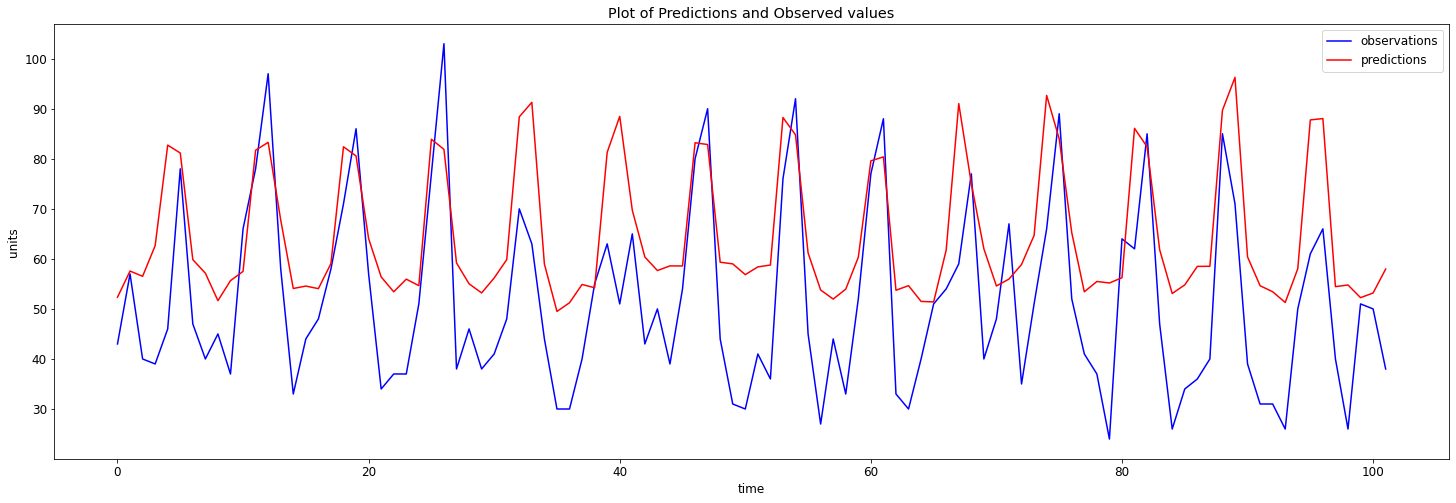

In [192]:
train_x, train_y, val_x, val_y = split_dataset(train_poly_df.drop(columns = ['date', 'codesum_rev']))
best_hyper_params, min_rmsle, rf_regressor, predictions = tune_rf_regressor(rf_hyper_params, train_x, train_y, val_x, val_y)
plot_observations_predictions(val_y.values, predictions)

Conclusion is simple, we need more date related features

#### Normalization of numerical vectors before feeding to RF Regressor

#### Let's do one thing, transform the numerical features, perform normalization on them

In [345]:
train_x, train_y, val_x, val_y = split_dataset(train_weather_df.drop(columns = ['date','codesum_rev']))

* Whatever normalization or standardization we apply, we'll first fit on train data.
* Use the Normalizer or Standardizer used for train data to transform validation data.
* Let's use min-max scaler for normalization.

In [346]:
import pandas as pd
from sklearn import preprocessing

x = train_x[transform_feat].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
train_x_transform_feat_norm = pd.DataFrame(x_scaled)

In [347]:
train_x_transform_feat_norm.columns = train_x[transform_feat].columns

In [348]:
train_x_transform_feat_norm.head()

,sealevel,wetbulb,resultspeed,preciptotal,tmax,dewpoint,heat,stnpressure,avgspeed,cool,tmin,resultdir,snowfall,tavg
0,0.941606,0.405797,0.102679,0.0,0.367347,0.328571,0.513889,0.956522,0.243243,0.0,0.416667,0.428571,0.0,0.393258
1,0.905109,0.507246,0.263393,0.0,0.489796,0.400000,0.444444,0.902174,0.274775,0.0,0.392857,0.428571,0.0,0.449438
2,0.678832,0.579710,0.120536,0.0,0.540816,0.385714,0.305556,0.739130,0.252252,0.0,0.571429,0.571429,0.0,0.561798
3,0.773723,0.565217,0.236607,0.0,0.571429,0.385714,0.305556,0.836957,0.243243,0.0,0.523810,0.514286,0.0,0.561798
4,0.540146,0.637681,0.178571,0.0,0.653061,0.457143,0.194444,0.586957,0.193694,0.0,0.619048,0.571429,0.0,0.651685


In [349]:
train_x[transform_feat] = train_x_transform_feat_norm

In [361]:
train_x.shape

(909, 28)

#### Now let's transform the validation data as well

In [365]:
validation_x_vals = val_x[transform_feat].values
val_x_scaled = min_max_scaler.transform(validation_x_vals)
val_x_transform_feat_norm = pd.DataFrame(val_x_scaled)
val_x_transform_feat_norm.columns = val_x[transform_feat].columns

In [369]:
val_x = val_x.reset_index()
val_x[transform_feat] = val_x_transform_feat_norm

In [372]:
val_x.drop(columns=['index'],inplace=True)

### Train a RF Regressor

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  45 out of  45 | elapsed:    4.7s finished


Best Hyper Params :  {'n_estimators': 10, 'max_depth': 5, 'n_jobs': -1}
Min RMSLE :  0.32667095106097455


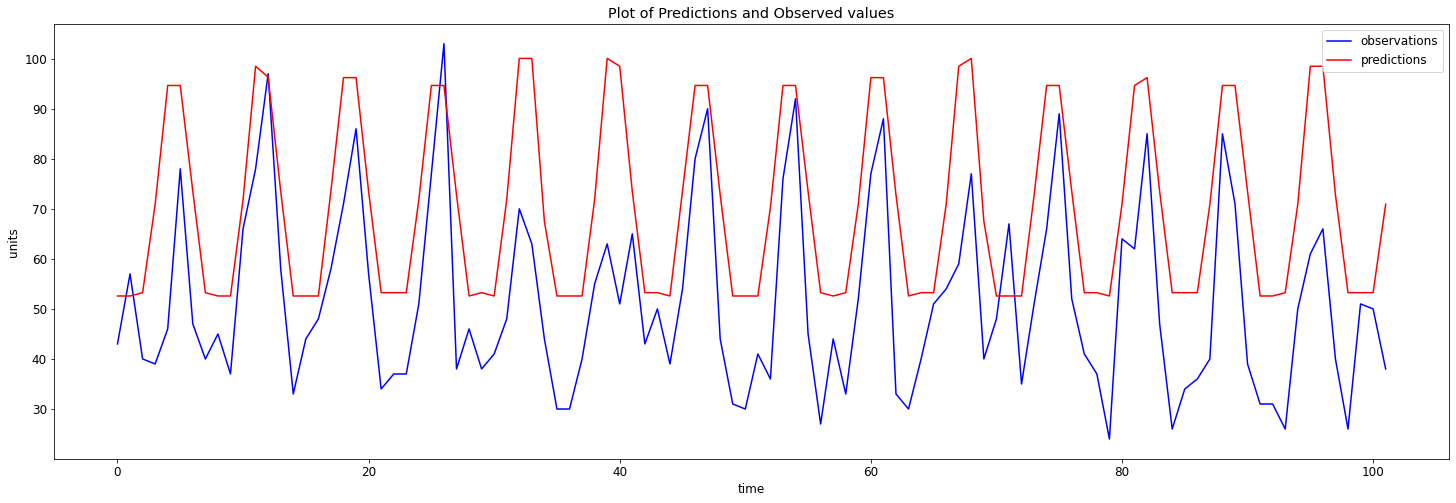

In [374]:
best_hyper_params, min_rmsle, rf_regressor, predictions = tune_rf_regressor(rf_hyper_params, train_x, train_y, val_x, val_y)
plot_observations_predictions(val_y.values, predictions)

* We couldn't find any improvement in results after normalizing.
* Now let's add date features.

### Adding more date features.
* Including major holidays.
* Including 2 days before and after holidays.
* List of holidays I'll be considering are Christmas, Thanksgiving, Mother's day, Easter, Independence day, Halloween, Father's day, Valentine's day, Saint Patrick's day, New year's day.
* We know that we have data of upto 3 years, so we'll create binary features for each of these days.
* Also three days before and after these days will be a special feature w.r.t each column.

In [381]:
import datetime

In [382]:
christmas_dates = [datetime.datetime(2012 + i, 12, 25) for i in range(3)]
thanksgiving_dates = [datetime.datetime(2012,11,22), datetime.datetime(2013,11,28), datetime.datetime(2014,11,27)]
black_friday_dates = [datetime.datetime(2012,11,23), datetime.datetime(2013,11,29), datetime.datetime(2014,11,28)]

In [391]:
christmas_dates_index = train_weather_df[train_weather_df['date'].isin(christmas_dates)].index
train_weather_df['christmas_dates'] = pd.Series(np.zeros((train_weather_df.shape[0])))

In [392]:
train_weather_df.loc[christmas_dates_index,'christmas_dates'] = 1

In [396]:
thanksgiving_dates_index = train_weather_df[train_weather_df['date'].isin(thanksgiving_dates)].index
train_weather_df['thanksgiving_dates'] = pd.Series(np.zeros((train_weather_df.shape[0])))
train_weather_df.loc[thanksgiving_dates_index,'thanksgiving_dates'] = 1

In [398]:
black_friday_dates_index = train_weather_df[train_weather_df['date'].isin(black_friday_dates)].index
train_weather_df['black_friday_dates'] = pd.Series(np.zeros((train_weather_df.shape[0])))
train_weather_df.loc[black_friday_dates_index,'black_friday_dates'] = 1

In [442]:
def create_days_col(inp_df, dates, col_name):
    dates_index = inp_df[inp_df['date'].isin(dates)].index
    inp_df[col_name] = pd.Series(np.zeros((inp_df.shape[0])))
    inp_df.loc[dates_index,col_name] = 1
    return inp_df

In [404]:
dates_df = train_weather_df[['christmas_dates','thanksgiving_dates','black_friday_dates','date']]
dates_df[dates_df['date'] == '2012-11-22']

,christmas_dates,thanksgiving_dates,black_friday_dates,date
326,0.0,1.0,0.0,2012-11-22


In [434]:
def create_preceeding_following_days(years, month, days):
    foll_days = []
    prec_days = []
    end_index = 3
    for year in years:
        for day in days:
            if month == 11:
                end_index = 2
            foll_year_days = [datetime.datetime(year,month,day+i) for i in range(1,end_index)]
            pre_year_days = [datetime.datetime(year,month,day-i) for i in range(1,end_index)]
        foll_days.extend(foll_year_days)
        prec_days.extend(pre_year_days)
        
    return prec_days + foll_days

In [435]:
christmas_day = [25]
christmas_month = 12
thanksgiving_days = [22,28,27]
thanksgiving_month = 11
blackfriday_days = [23,29,28]
blackfriday_month = 11

years = [2012,2013,2014]

In [436]:
christmas_pre_foll_days = create_preceeding_following_days(years, christmas_month, christmas_day)
thanksgiving_pre_foll_days = create_preceeding_following_days(years, thanksgiving_month, thanksgiving_days)
blackfriday_pre_foll_days = create_preceeding_following_days(years, blackfriday_month, blackfriday_days)

In [445]:
train_weather_df = create_days_col(train_weather_df,christmas_pre_foll_days,'christmas_margin_days')
train_weather_df = create_days_col(train_weather_df,thanksgiving_pre_foll_days,'thanksgiving_margin_days')
train_weather_df = create_days_col(train_weather_df,blackfriday_pre_foll_days,'blackfriday_margin_days')

In [448]:
train_x, train_y, val_x, val_y = split_dataset(train_weather_df.drop(columns = ['date','codesum_rev']))

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  45 out of  45 | elapsed:    5.5s finished


Best Hyper Params :  {'n_estimators': 10, 'max_depth': 10, 'n_jobs': -1}
Min RMSLE :  0.31525987594357324


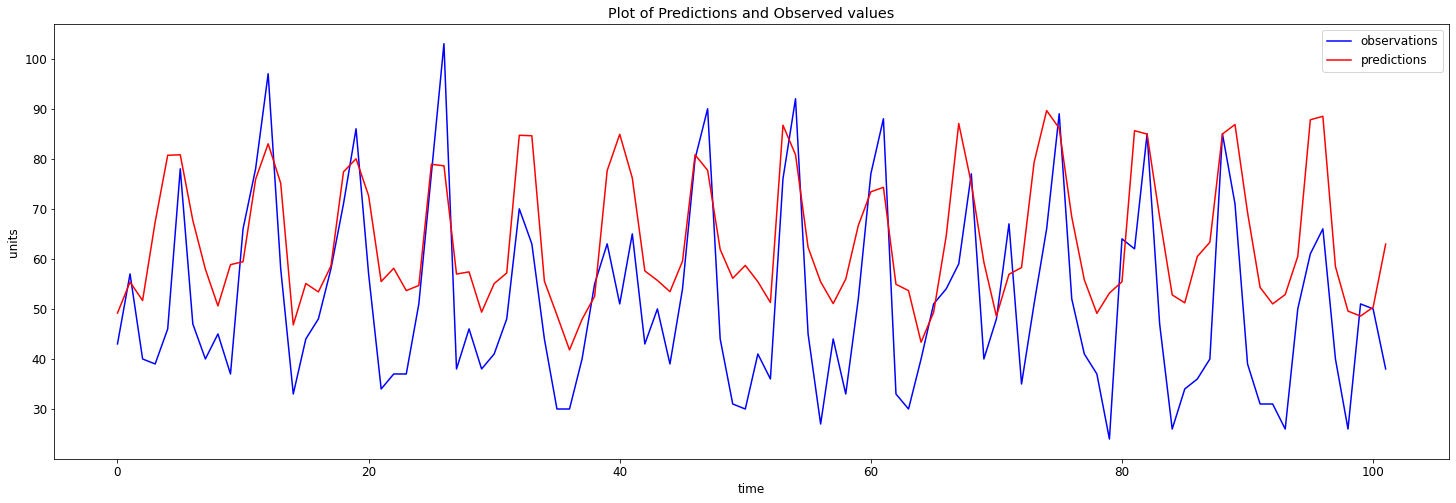

In [462]:
best_hyper_params, min_rmsle, rf_regressor, predictions = tune_rf_regressor(rf_hyper_params, train_x, train_y, val_x, val_y)
plot_observations_predictions(val_y.values, predictions)

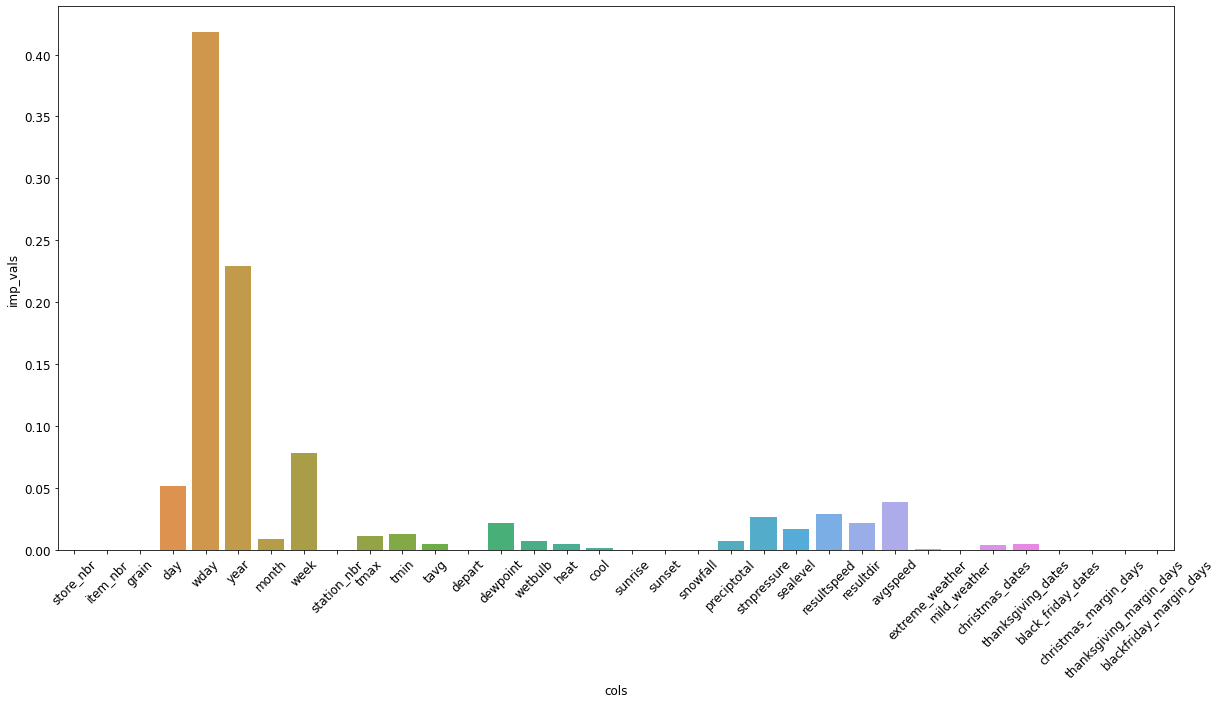

In [469]:
get_feature_importances(train_x, rf_regressor)

#### Some trick, let's see if it works
* It can be noticed that the lower values clip at around 50, so if we pulldown the lower values(lower than mean) by some val
* If the value of prediction is less than the mean prediction, then new prediction = prediction - diff
* Here difference is the hyper-parameter we are tuning for.

In [466]:
mean_prediction = np.mean(predictions)
diff_param = [i for i in range(10,30,5)]
best_diff_param = 0
min_rmsle = np.inf
new_predictions = predictions.copy()
for diff in diff_param:
    print("Diff param : ", diff)
    new_predictions = predictions.copy()
    for i in range(len(predictions)):
        if predictions[i] < mean_prediction:
            new_predictions[i] = predictions[i]-diff
    
    rmsle = calc_rmsle(predictions, val_y.values)
    if rmsle < min_rmsle :
        best_diff_param = diff
        min_rmsle = rmsle

print("Minimum RMSLE : ", min_rmsle)
print("Best difference parameter : ", best_diff_param)
new_predictions = predictions.copy()
for i in range(len(predictions)):
    if predictions[i] < mean_prediction:
        new_predictions[i] = predictions[i]-best_diff_param

Diff param :  10
Diff param :  15
Diff param :  20
Diff param :  25
Minimum RMSLE :  0.3318071722653546
Best difference parameter :  10


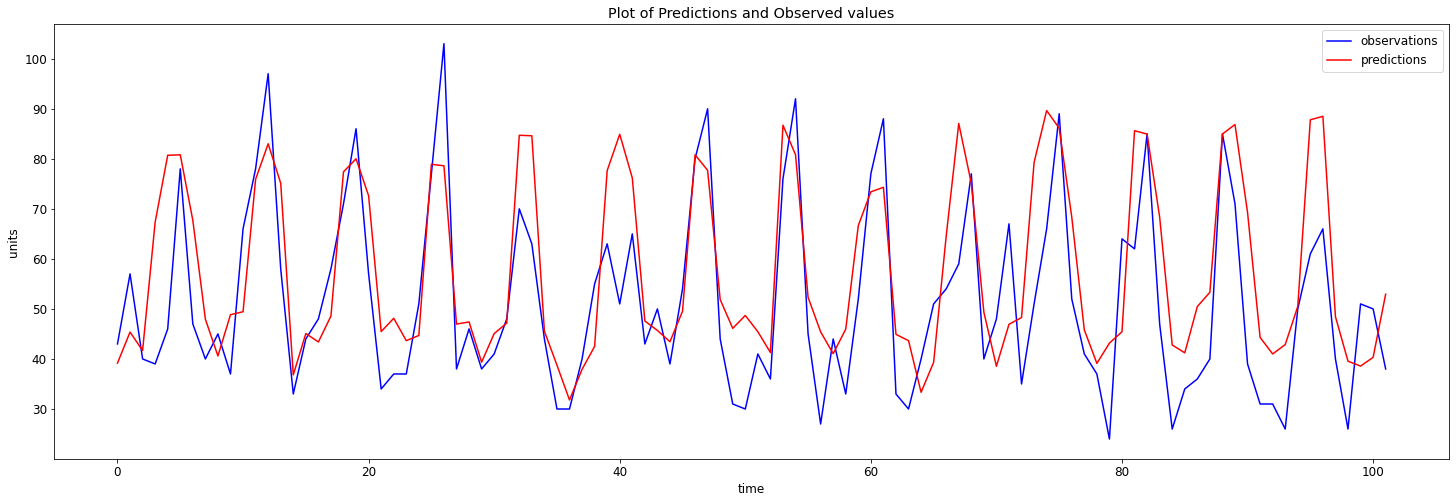

In [467]:
plot_observations_predictions(val_y.values, new_predictions)

Predictions fit better but RMSLE value didn't decrease much

### Conclusion
* So with a mix of Random Forest Regressor and some rule based modifications. we can train our model, which fits the validation points better and gives decent Root Mean squared log error.